This program will grab the current active watches and warnings from the NWS API service and plot them on the grids using the python-awips coloring package for NWS watches and warnings.

Note: In the awips-python package, there is currently no coloring set for special weather statements and a couple others. Those colors will be prepended as this program is updated. Currently, special weather statements are prepended to be shaded in 'moccasin'.

In [1]:
#Import the necessary packages
import datetime
from awips.tables import vtec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from metpy.units import units
from noaa_sdk import noaa
import pandas as pd
import shapely
from shapely.geometry import Polygon, MultiPolygon
import requests

We import cartopy packages for the plotting as well as the noaa_sdk which serves as our loading point for the NWS API. This package is maintained by another source, so things could potentially break, but this program will be ammended as that happens.

Now let's define the functions that we need for grabbing our colors and creating the map. We are going to start with an overall map of the United States. Later on, we will go into mapping by Regions and showing a legend with the active alerts and their corresponding colors labelled.

In [2]:
# Function we will need to grab the warning colors
def warning_color(phensig):
    if (phensig == 'Special Weather Statement'
            or phensig == "Marine Weather Statement"):
        color = 'moccasin'
    elif phensig == "Rip Current Statement":
        color = "aqua"
    else:
        for val in vtec:
            event_val = vtec[val]['hdln']
            if (event_val == phensig):
                color = vtec[val]['color']
    return color


In [33]:
#Function to create the initial map
def make_map(proj=ccrs.LambertConformal(central_longitude=-95, central_latitude=30,standard_parallels=[35])):
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw=dict(projection=proj))
    ax.set_extent([-130, -60, 20, 50.5],ccrs.PlateCarree())
    #gl = ax.gridlines(draw_labels=True, color='#e7e7e7')
    #gl.xlabels_top = gl.ylabels_right = True
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return fig, ax


def make_region_map(proj=ccrs.PlateCarree(), bbox=None):
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw=dict(projection=proj))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True, color='#e7e7e7')
    gl.xlabels_top = gl.ylabels_right = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# Definitions for each area we will be using for subregions
# Northeast
ne = shapely.geometry.box(-80, 30, -60, 50, ccw=True)
# Rockies
rs = shapely.geometry.box(-115, 30, -95, 50, ccw=True)
# Southeast
se = shapely.geometry.box(-90, 20, -70, 40, ccw=True)
# Ohio Valley
ov = shapely.geometry.box(-95, 25, -75, 45, ccw=True)
# Upper MidWest
um = shapely.geometry.box(-100, 30, -80, 50, ccw=True)
# West
weast = shapely.geometry.box(-125, 23, -105, 43, ccw=True)
# Northwest
nw = shapely.geometry.box(-125, 30, -100, 50, ccw=True)
# South
south = shapely.geometry.box(-115, 20, -90, 40, ccw=True)

# Bounding boxes per region
bbox_ne = [-80, -60, 30, 50]
bbox_rs = [-115, -95, 30, 50]
bbox_se = [-90, -70, 20, 40]
bbox_ov = [-95, -75, 25, 45]
bbox_um = [-100, -80, 30, 50]
bbox_weast = [-125, -105, 23, 43]
bbox_nw = [-125, -100, 30, 50]
bbox_south = [-115, -90, 20, 40]

Now we will connect to the NWS API and collect the current active alerts

In [5]:
# Open the NWS API in python to get the active alerts
n = noaa.NOAA()
alerts = n.active_alerts()

Next, we will get the shapefile for the NWS forecast zones. The NWS alerts do come with polygon definitions, however these are not always given correctly or even given at all for the shapely plotting program to use. Rather than going through and reformatting those, we will instead pull the name of the forecast zone from the NWS API call and plot it's polygon from the shapefile.

In [6]:
# Get the shapefiles for the zones and puth the zone names and their
# geometries into a pandas DataFrame for use when plotting.
reader = shpreader.Reader('shapefiles/c_02jn20.shp')
list_records = []
list_geometries = []
list_records.append([c.attributes for c in list(reader.records())])
list_geometries.append([c for c in list(reader.geometries())])
df = pd.DataFrame.from_dict(list_records[0], orient='columns', dtype=None)

# list to hold tuples consisting of the polygon, the event associated with it,
# and its color
data_array = []

# CONUS Plot

Now that we have both the alerts and polygons loaded, along with the list to hold the tuples we will plot, we can go ahead and loop through all of the alerts. For each alert, we will find the alert, get its polygon coordinates either from the NWS API call or the shapefile, get its associated color, and its regional location based on the latitude and longitude definitions we provided earlier. Then the program will do two things, first, the information for each location's alert will be put into a tuple and saved to the list we initiated earlier. This will be used for region by region plotting. Second, the program will plot our current alert on the overall CONUS map.

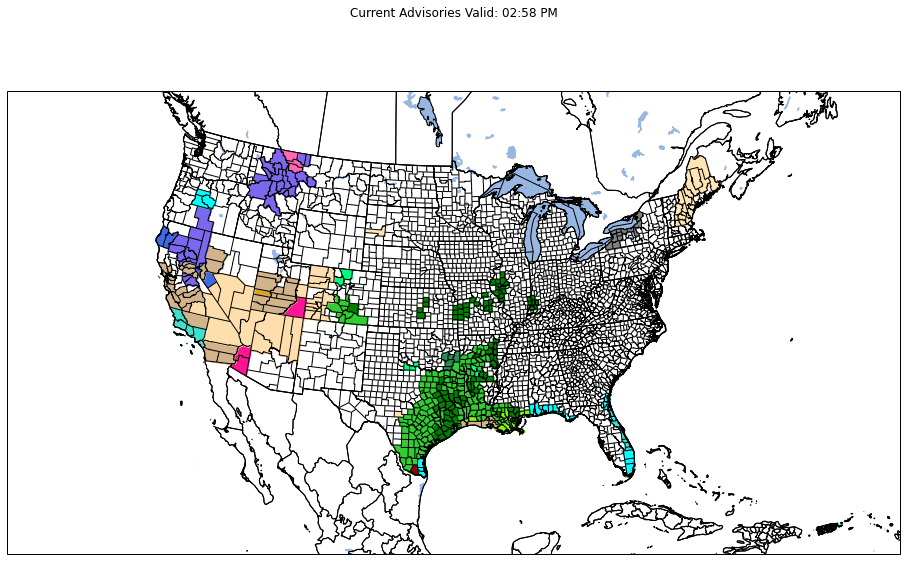

In [36]:
# Define the figure and add in the states, counties, oceans, and lakes
fig, ax = make_map()
reader = shpreader.Reader('shapefiles/countyl010g.shp')
ax.add_feature(cfeature.LAKES.with_scale('50m'))
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties,ccrs.PlateCarree())
shape_feature = cfeature.STATES.with_scale('10m')
ax.add_feature(shape_feature)


# Now loop through each of the individual alerts in the overall alerts. Need
# to take the 'features' class to access the 'events' and 'geometry'
# properties.
for alert in alerts['features']:
    # Now use a try and except statement to test if there is an alert. If no
    # alert, will go to next one. If there is an alert, we will plot the
    # shapefile of the alert on the map
    try:
        # Get the event name
        event = alert['properties']['event']
        # Now get the coordinates listed for the alert. Sometimes it is a
        # MultiPolygon object, so we use a loop to grab each object in the
        # 'coordinates' property to be able to plot everything.
        for zz in alert['properties']['geocode']['SAME']:
            loc = []
            # Sometimes coordinates will return None, if so, skip over it.
            if zz:
                # Get the coordinates
                poly_coords = zz[1:]

                # Get the index in the dataframe and pull out the geometry
                ind = df.index[df.FIPS == poly_coords][0]
                polygon = list_geometries[0][ind]
                # get the x and y coordinates into two separate lists
                # xcoor, ycoor = map(list, zip(*poly_coords))

                # Now place them into tuples for each coordinate pair and put
                # the tuples into a list coords = list(zip(xcoor, ycoor))

                # Create a shapely.Polygon object from the coordinates
                # polygon = Polygon(coords)

                if ne.contains(polygon):
                    loc.append('ne')
                if rs.contains(polygon):
                    loc.append('rs')
                if se.contains(polygon):
                    loc.append('se')
                if ov.contains(polygon):
                    loc.append('ov')
                if um.contains(polygon):
                    loc.append('um')
                if weast.contains(polygon):
                    loc.append('weast')
                if nw.contains(polygon):
                    loc.append('nw')
                if south.contains(polygon):
                    loc.append('south')

                # Call the warning_color function to get the color to plot
                wcolor = warning_color(event)
                for location in loc:
                    data_array.append((polygon, event, wcolor, location))

                # Now add the feature to the axis. We use [polygon] as the
                # ShapelyFeature takes a list of objects
                shape_feature = ShapelyFeature([polygon], ccrs.PlateCarree(),
                                               facecolor=wcolor,
                                               edgecolor=wcolor)
                ax.add_feature(shape_feature)
    except:
        # Sometimes, the coordinates return None due to NWS not listing them
        # on the API for the alert. In this case, we grab the affected zone(s)
        # and get their coordinates to plot the alert for
        try:
            # Grab each of the affected zones (note there can be just a single
            # affected zone)
            for zi in alert['properties']['affectedZones']:

                # Grabbing the zone leaves a http link to the zone itself, so we
                # need to access the JSON object using the python requests API
                zone_info = requests.get(alert['properties']['affectedZones'][0]).json()

                # Use another try and except block to check for the coordinates.
                # Sometimes the coordinates are contained in 'geometry''geometries',
                # so we need to check.
                try:
                    # Same as above. If it is a MultiPolygon, we loop through each
                    # set of coordinates. Will still work if only a Polygon
                    for zz in zone_info['geometry']['coordinates'][0][0]:
                        # PC represents the coordinates inside the MultiPolygon
                        # coordinates variable (zz)
                        for pc in zz:
                            loc = []
                            # Now try and plot, if coordinates return None,
                            # skip them.
                            if pc:
                                # Grab the set of coordinates
                                poly_coords = pc

                                # get the x and y coordinates into two separate
                                # lists
                                xcoor, ycoor = map(list, zip(*poly_coords))

                                # Combine the two lists into tuples of coordinates
                                # and put the tuples into a new list
                                coords = list(zip(xcoor, ycoor))

                                # Create a shapely.Polygon from the coordinate
                                # tuples
                                polygon = Polygon(coords)

                                if ne.contains(polygon):
                                    loc.append('ne')
                                if rs.contains(polygon):
                                    loc.append('rs')
                                if se.contains(polygon):
                                    loc.append('se')
                                if ov.contains(polygon):
                                    loc.append('ov')
                                if um.contains(polygon):
                                    loc.append('um')
                                if weast.contains(polygon):
                                    loc.append('weast')
                                if nw.contains(polygon):
                                    loc.append('nw')
                                if south.contains(polygon):
                                    loc.append('south')

                                # Call the warning_color function to get the color
                                # to plot
                                wcolor = warning_color(event)
                                for location in loc:
                                    data_array.append((polygon, event, wcolor,
                                                       location))

                                # Now add the feature to the axis. We use [polygon]
                                # as the ShapelyFeature takes a list of objects
                                shape_feature = ShapelyFeature([polygon],
                                                               ccrs.PlateCarree(),
                                                               facecolor=wcolor,
                                                               edgecolor=wcolor)
                                ax.add_feature(shape_feature)
                except:
                    # Same as above for when the coordinates are in 'geometry'
                    # 'geometries'
                    for zg in zone_info['geometry']['geometries']:
                        try:
                            # Have to grab the coordinates out of the 'geometry'
                            # 'geometries' list
                            for zgg in zg['coordinates']:
                                for pc in zgg:
                                    loc = []
                                    # Now try and plot, if coordinates return None,
                                    # skip them.
                                    if pc:
                                        # Grab the set of coordinates
                                        poly_coords = pc

                                        # get the x and y coordinates into two
                                        # separate lists
                                        xcoor, ycoor = map(list, zip(*poly_coords))

                                        # Combine the two lists into tuples of
                                        # coordinates and put the tuples into
                                        # a new list
                                        coords = list(zip(xcoor, ycoor))

                                        # Create a shapely.Polygon from the
                                        # coordinate tuples
                                        polygon = Polygon(coords)

                                        if ne.contains(polygon):
                                            loc.append('ne')
                                        if rs.contains(polygon):
                                            loc.append('rs')
                                        if se.contains(polygon):
                                            loc.append('se')
                                        if ov.contains(polygon):
                                            loc.append('ov')
                                        if um.contains(polygon):
                                            loc.append('um')
                                        if weast.contains(polygon):
                                            loc.append('weast')
                                        if nw.contains(polygon):
                                            loc.append('nw')
                                        if south.contains(polygon):
                                            loc.append('south')

                                        # Call the warning_color function to get
                                        # the color to plot
                                        wcolor = warning_color(event)
                                        for location in loc:
                                            data_array.append((polygon, event,
                                                               wcolor,
                                                               location))

                                        # Now add the feature to the axis. We use
                                        # [polygon] as the ShapelyFeature takes a
                                        # list of objects
                                        shape_feature = ShapelyFeature([polygon],
                                                                       ccrs.PlateCarree(),
                                                                       facecolor=wcolor,
                                                                       edgecolor=wcolor)
                                        ax.add_feature(shape_feature)
                        except:
                            pass
        except:
            pass
# Add in the counties and coastline here to overlay them on the warning polygons
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_title("Current Advisories Valid: " + datetime.datetime.now().strftime("%I:%M %p"),
             pad=75)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black')
# plt.savefig('continentalus.png', bbox_inches='tight')

The above map can be combined with the bokeh, geopandas, geoviews, and holoviews python packages to enable the user to mouse over the different counties and get information about the current active alerts. 

Check out it running in real time [here!](https://storm.uml.edu/~metweb/geoviews-examples/output1.html)

### Note: Not yet optimized for mobile users and is slow to load due to amount of data!

# Regional Plots

Making the regional plots is straightforward at this point. We will turn our list of tuples into a pandas dataframe for easier accessability and indexing. Then we can group by the geographic location and plot the corresponding groups of polygons. Here we also include a legend since there is less data plotted. Using a legend on the CONUS map is possible, but will become illegible due to the shear amount of alerts that could be occuring in any given NWS API call.

C:\Users\CoeFamily\.conda\envs\meteorology\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


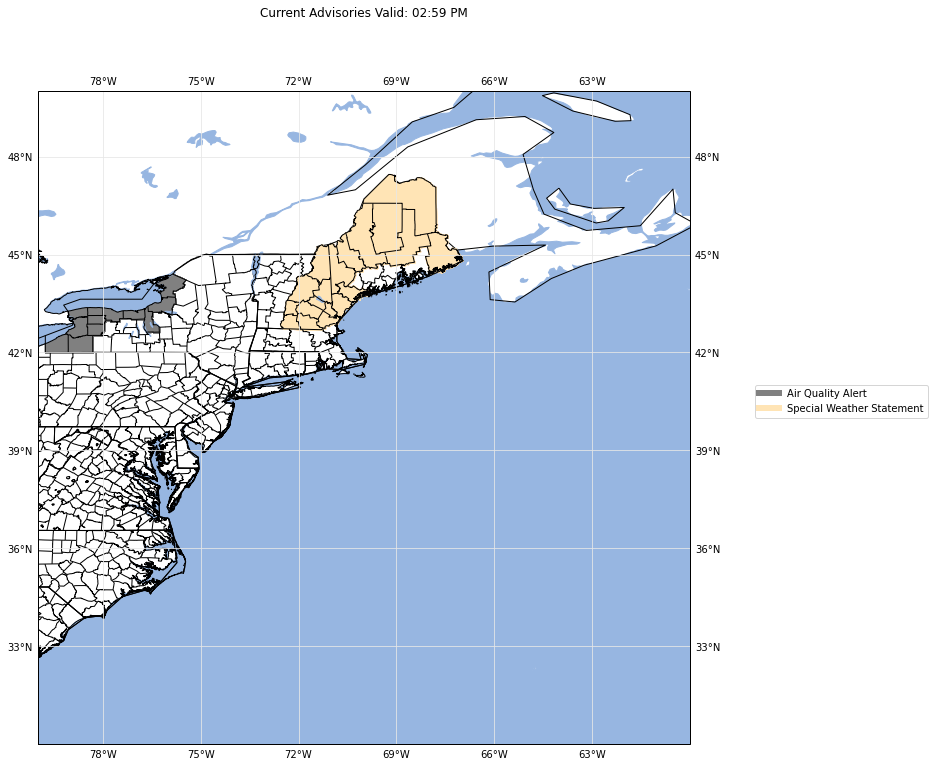

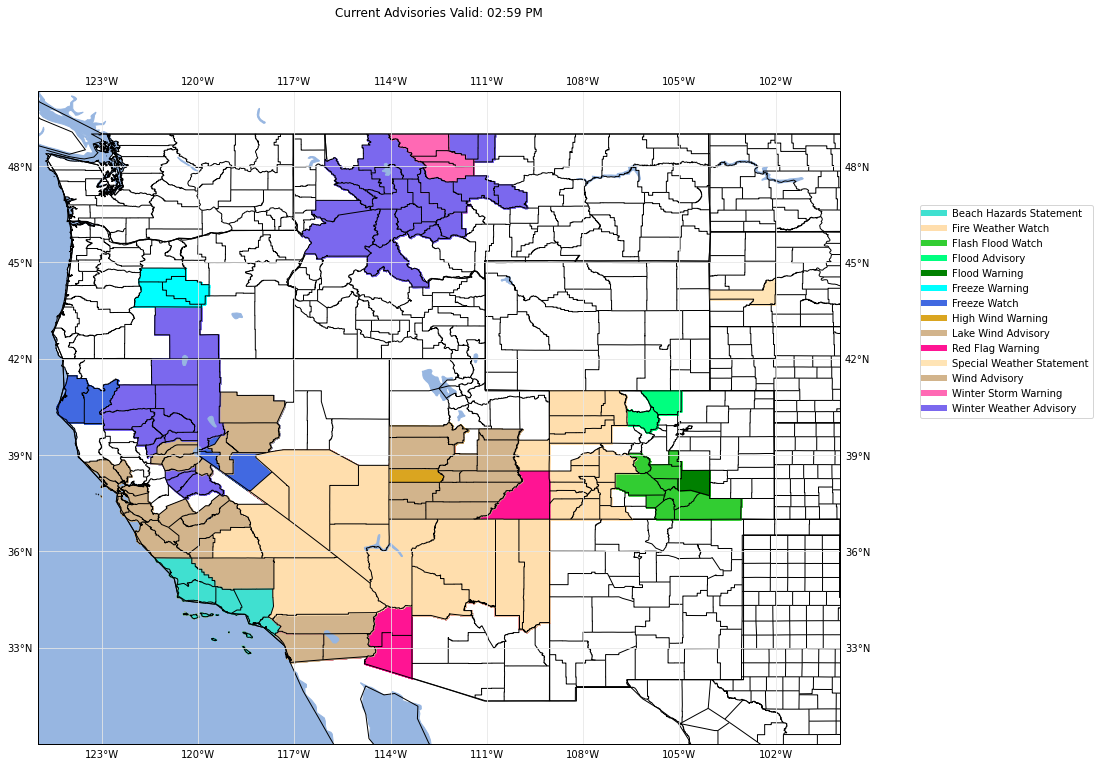

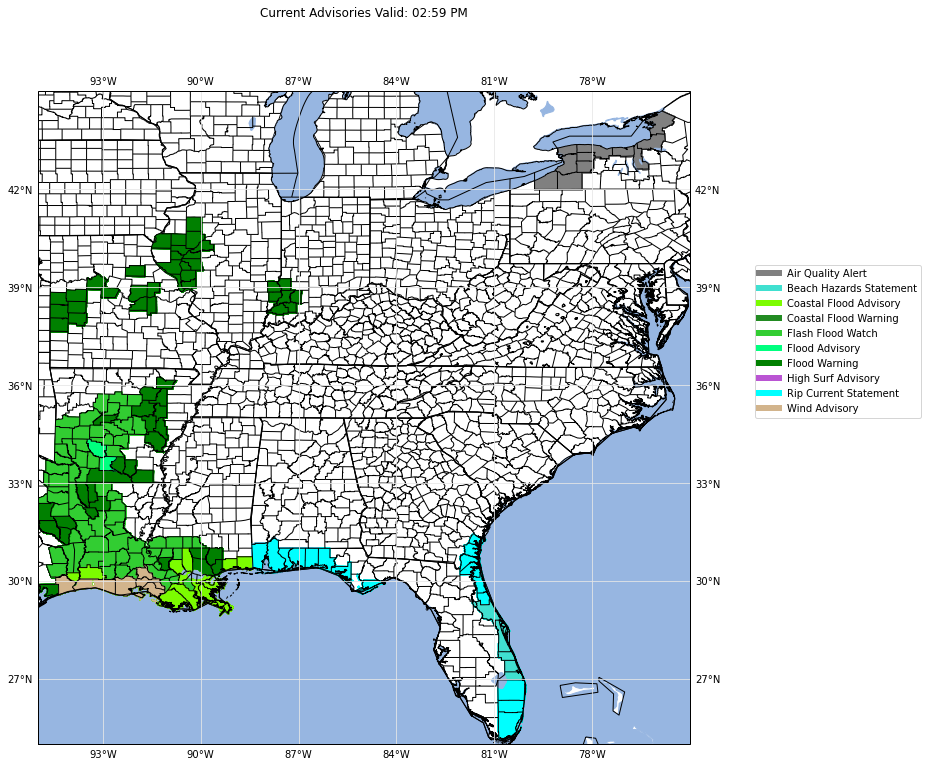

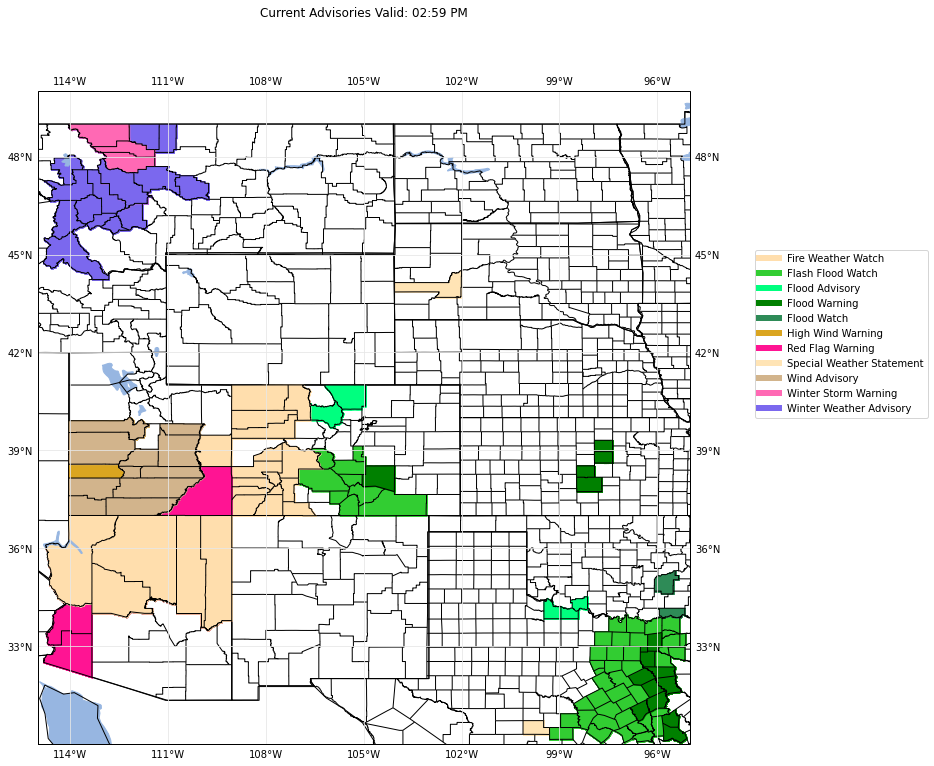

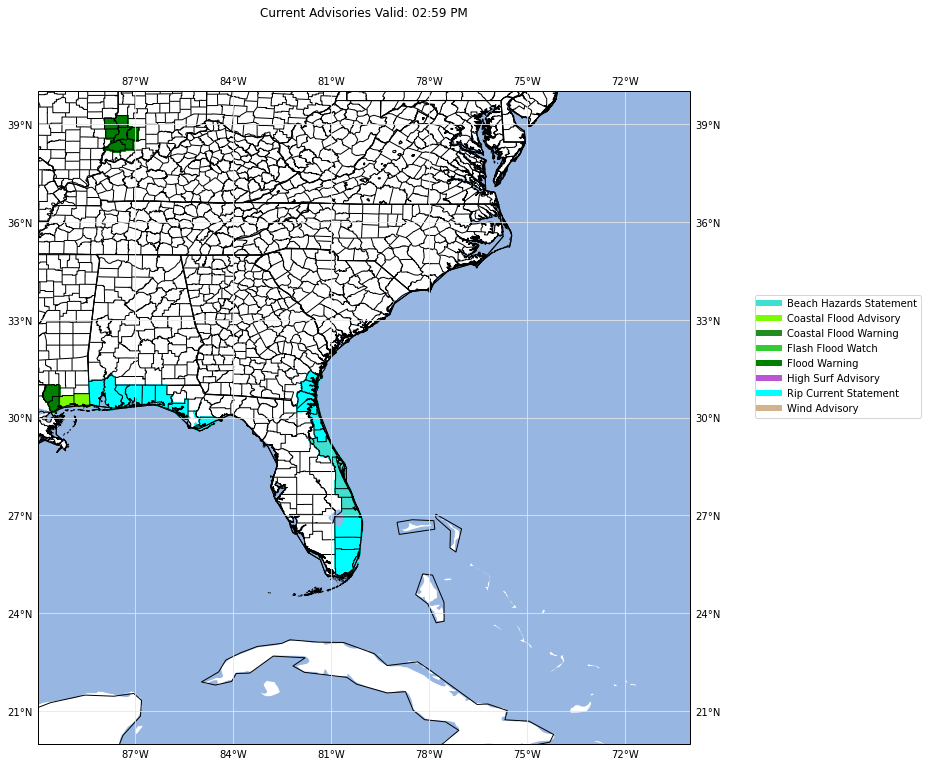

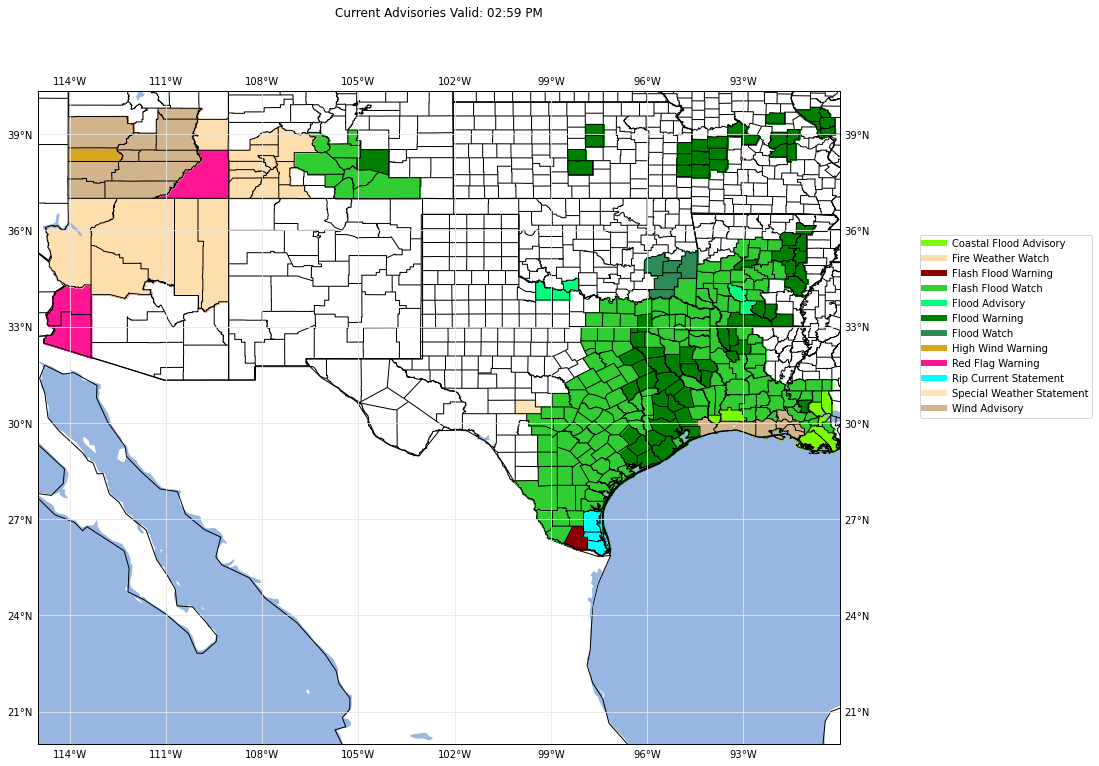

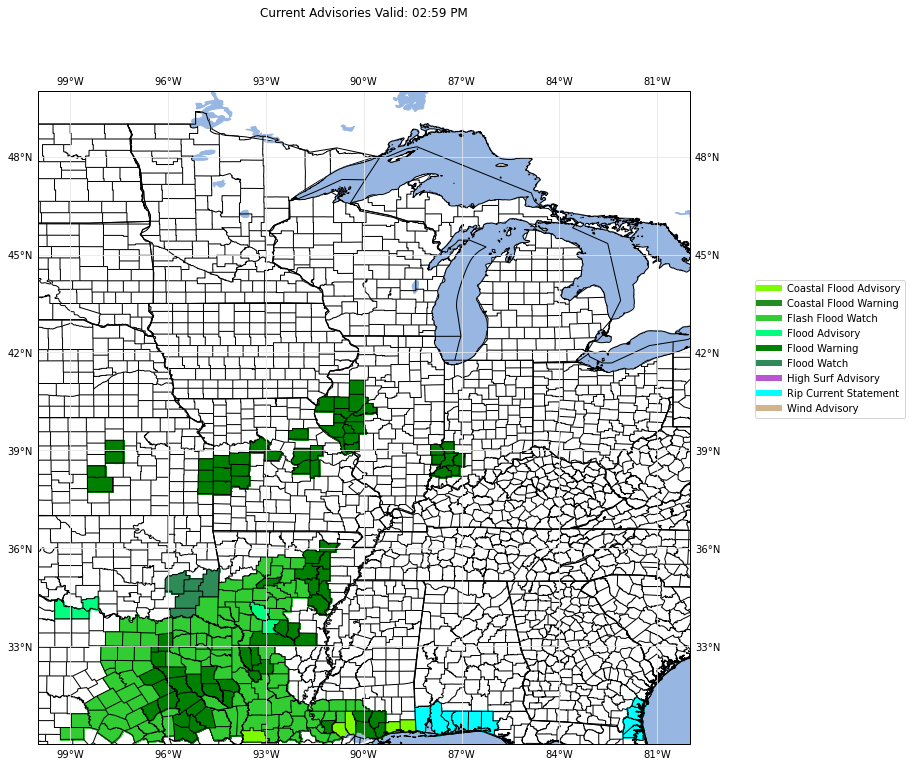

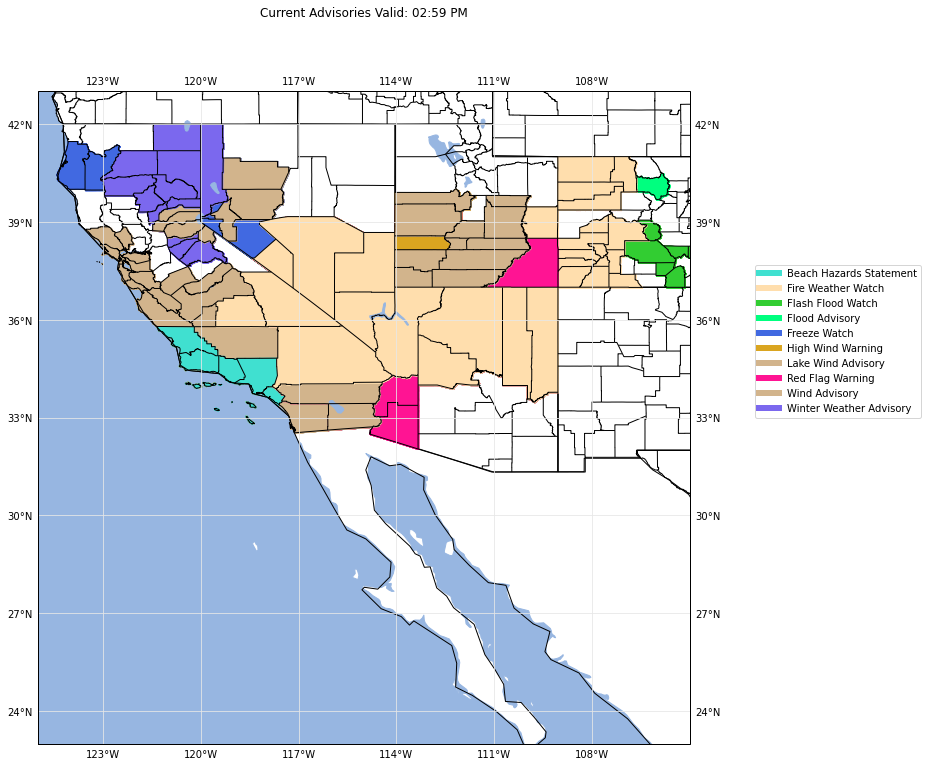

In [37]:
# Now make the regional maps and add in legends
df = pd.DataFrame(data_array)

for group in df.groupby(df[3]):

    name = group[0]
    
    # Get the corresponding bounding box for the region
    if name == 'ne':
        boxx = bbox_ne
    elif name == 'nw':
        boxx = bbox_nw
    elif name == 'ov':
        boxx = bbox_ov
    elif name == 'rs':
        boxx = bbox_rs
    elif name == 'se':
        boxx = bbox_se
    elif name == 'south':
        boxx = bbox_south
    elif name == 'um':
        boxx = bbox_um
    else:
        boxx = bbox_weast

    # Create the map for the region with its defined counding box
    fig, ax = make_region_map(ccrs.PlateCarree(), boxx)
    shape_feature = cfeature.STATES
    ax.add_feature(shape_feature)

    # Plot the data
    for val, val1, wcolor, val3 in group[1].itertuples(index=False):
        # Now add the feature to the axis. We use [polygon] as the ShapelyFeature
        # takes a list of objects
        shape_feature = ShapelyFeature([val], ccrs.PlateCarree(),
                                       facecolor=wcolor, edgecolor=wcolor)
        ax.add_feature(shape_feature)

    # Now add in the legend
    # Get the color and advisory into its own group
    legend_list = []
    for group in group[1].groupby([group[1][1], group[1][2]]):
        legend_list.append(group)
    warning = []
    custom_lines = []
    for group in legend_list:
        warning.append(group[0][0])
        custom_lines.append(Line2D([0], [0], color=group[0][1], lw=6))
    ax.legend(custom_lines, warning, loc=(1.10, 0.5))
    plt.tight_layout()

    # Add in the counties
    ax.add_feature(cfeature.COASTLINE)  
    reader = shpreader.Reader('countyl010g.shp')
    counties = list(reader.geometries())
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.LAKES.with_scale('50m'))
    ax.set_title("Current Advisories Valid: " + datetime.datetime.now().strftime("%I:%M %p"),
                 pad=75)
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='black')

#     plt.savefig(name + '.png', bbox_inches='tight')
#     plt.close()